In [1]:
#----------week1-------------

In [2]:
# 라이브러리 import 및 TensorFlow 버전 확인

import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [3]:
# 데이터 다운로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

14628807/14628807 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4893335/4893335 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# IN - 텍스트로 로드
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300])

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [5]:
# IN - Y(정답 라벨) 데이터 만들기
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [6]:
import re

def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
<>:13: SyntaxWarning: invalid escape sequence '\('
<>:14: SyntaxWarning: invalid escape sequence '\)'
<>:15: SyntaxWarning: invalid escape sequence '\?'
/tmp/ipython-input-2842916861.py:13: SyntaxWarning: invalid escape sequence '\('
  string = re.sub(r"\(", " \( ", string)
/tmp/ipython-input-2842916861.py:14: SyntaxWarning: invalid escape sequence '\)'
  string = re.sub(r"\)", " \) ", string)
/tmp/ipython-input-2842916861.py:15: SyntaxWarning: invalid escape sequence '\?'
  string = re.sub(r"\?", " \? ", string)


['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [7]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 586    1    1    1    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   68  345   28   33    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  102    1    2    1    1  844    1    1  570    1    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


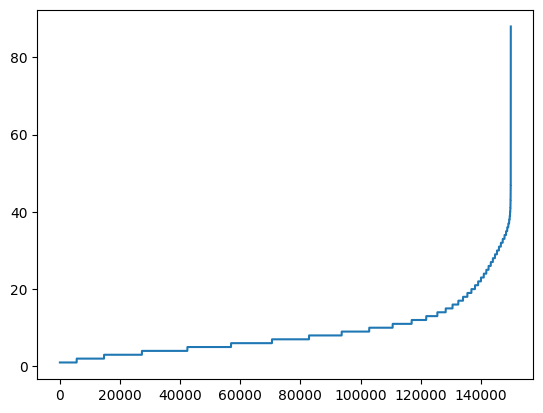

142587


In [8]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [9]:
#----------week2-------------

In [10]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

# Week1에서 학습된 vectorize_layer 그대로 사용합니다.
test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)

test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [11]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,321 (1.01 MB)

 Trainable params: 264,321 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6727 - loss: 0.5617 - val_accuracy: 0.7573 - val_loss: 0.4614
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7535 - loss: 0.4614 - val_accuracy: 0.7563 - val_loss: 0.4608
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7538 - loss: 0.4562 - val_accuracy: 0.7602 - val_loss: 0.4567
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7556 - loss: 0.4507 - val_accuracy: 0.7612 - val_loss: 0.4611
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7585 - loss: 0.4452 - val_accuracy: 0.7600 - val_loss: 0.4567
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7615 - loss: 0.4432 - val_accuracy: 0.7541 - val_loss: 0.4632
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7628 - loss: 0.4383 - val_accuracy: 0.7597 - val_loss: 0.4613
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7665 - loss: 0.4343 -

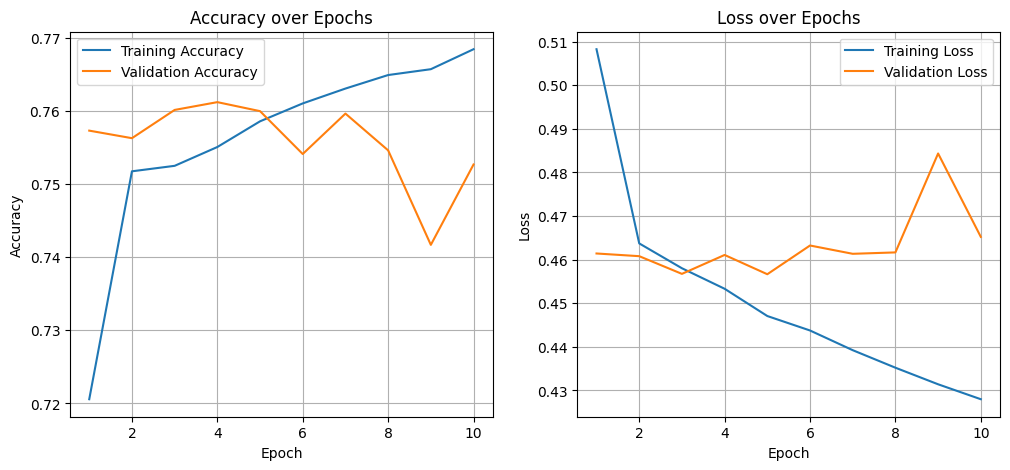

In [15]:
# epoch=10
import matplotlib.pyplot as plt

# 학습 결과에서 accuracy와 loss 가져오기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# ---- 그래프 그리기 ----
plt.figure(figsize=(12, 5))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [16]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 30
BATCH_SIZE = 32

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.7727 - loss: 0.4214 - val_accuracy: 0.7467 - val_loss: 0.4711
Epoch 2/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7750 - loss: 0.4199 - val_accuracy: 0.7501 - val_loss: 0.4716
Epoch 3/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7751 - loss: 0.4156 - val_accuracy: 0.7576 - val_loss: 0.4688
Epoch 4/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7763 - loss: 0.4116 - val_accuracy: 0.7475 - val_loss: 0.4776
Epoch 5/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7795 - loss: 0.4096 - val_accuracy: 0.7521 - val_loss: 0.4783
Epoch 6/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7820 - loss: 0.4054 - val_accuracy: 0.7553 - val_loss: 0.4814
Epoch 7/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7837 - loss: 0.4036 - val_accuracy: 0.7516 - val_loss: 0.4809
Epoch 8/30
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7837 - loss: 0.4007 -

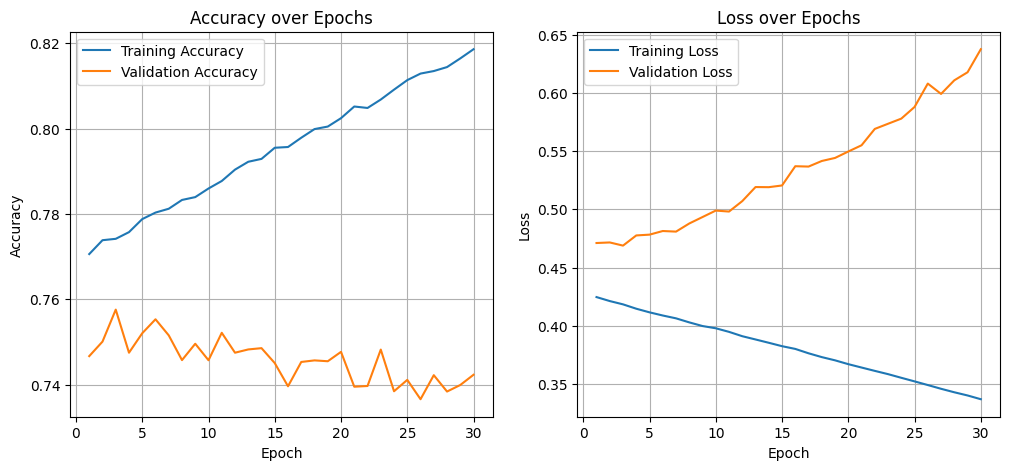

In [17]:
# epoch=30
import matplotlib.pyplot as plt

# 학습 결과에서 accuracy와 loss 가져오기
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# ---- 그래프 그리기 ----
plt.figure(figsize=(12, 5))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6483, Test Accuracy: 0.7249


In [19]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9912
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0001
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0006
결과: 부정 😞


In [20]:
#----------week3-------------

In [21]:
from tensorflow.keras.layers import SimpleRNN
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rnn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),
    SimpleRNN(units=50), #RNN 사용
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

rnn_model.summary()
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         8,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,279 (1.02 MB)

 Trainable params: 268,279 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_rnn = rnn_model.fit(
	train_X, train_Y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_split=0.2,
	verbose=1
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.6587 - loss: 0.5898 - val_accuracy: 0.7345 - val_loss: 0.4923
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7421 - loss: 0.4806 - val_accuracy: 0.7488 - val_loss: 0.4745
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7515 - loss: 0.4636 - val_accuracy: 0.7335 - val_loss: 0.4910
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.7597 - loss: 0.4513 - val_accuracy: 0.7543 - val_loss: 0.4765
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7635 - loss: 0.4434 - val_accuracy: 0.7547 - val_loss: 0.4864
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7664 - loss: 0.4380 - val_accuracy: 0.7549 - val_loss: 0.4939
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7694 - loss: 0.4347 - val_accuracy: 0.7544 - val_loss: 0.4967
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.7706 - loss: 0

In [23]:
test_loss, test_acc = rnn_model.evaluate(test_X, test_Y, verbose=0)
print(f"Rnn Test Loss: {test_loss:.4f}, Rnn Test Accuracy: {test_acc:.4f}")

Rnn Test Loss: 0.5127, Rnn Test Accuracy: 0.7373


In [24]:
# RNN 모델

In [25]:
example_sentences = [
    "배우 연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = rnn_model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0108
결과: 부정 😞
문장: 스토리는 아쉬웠지만 배우 연기는 좋았다
긍정 확률: 0.6255
결과: 긍정 😊


In [26]:
# Dense 모델

In [27]:
example_sentences = [
    "배우연기는 좋았지만 스토리가 아쉬웠다",
    "스토리는 아쉬웠지만 배우 연기는 좋았다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
문장: 배우연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0148
결과: 부정 😞
문장: 스토리는 아쉬웠지만 배우 연기는 좋았다
긍정 확률: 0.5909
결과: 긍정 😊


In [28]:
# 실습

In [31]:
from tensorflow.keras.layers import LSTM
import random

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 32

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

lstm_model = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LEN,)),
    tf.keras.layers.Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_LEN
    ),
    LSTM(units=50),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

lstm_model.summary()
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history_rnn = lstm_model.fit(
	train_X, train_Y,
	epochs=EPOCHS,
	batch_size=BATCH_SIZE,
	validation_split=0.2,
	verbose=1
)


test_loss, test_acc = lstm_model.evaluate(test_X, test_Y, verbose=0)
print(f"LSTM Test Loss: {test_loss:.4f}, LSTM Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 25, 128)        │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        35,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 295,129 (1.13 MB)

 Trainable params: 295,129 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.6515 - loss: 0.5742 - val_accuracy: 0.7567 - val_loss: 0.4578
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7542 - loss: 0.4569 - val_accuracy: 0.7609 - val_loss: 0.4575
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7609 - loss: 0.4421 - val_accuracy: 0.7597 - val_loss: 0.4636
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7656 - loss: 0.4290 - val_accuracy: 0.7575 - val_loss: 0.4706
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7723 - loss: 0.4155 - val_accuracy: 0.7610 - val_loss: 0.4786
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7769 - loss: 0.4029 - val_accuracy: 0.7564 - val_loss: 0.4900
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7834 - loss: 0.3915 - val_accuracy: 0.7589 - val_loss: 0.5044
Epoch 8/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7891 - loss: 0

In [32]:
#실습 RNN
example_sentences = [
  "이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽해서 끝까지 눈을 뗄 수 없었었요.",
  "영화가 전체적으로 너무 지루하고 전개가 느려서 몰입하기 힘들었으며, 기대했던 재미나 감동이 전혀 없었어요."
]

example_seq = vectorize_layer(example_sentences)
pred = rnn_model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
문장: 이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽해서 끝까지 눈을 뗄 수 없었었요.
긍정 확률: 0.9848
결과: 긍정 😊
문장: 영화가 전체적으로 너무 지루하고 전개가 느려서 몰입하기 힘들었으며, 기대했던 재미나 감동이 전혀 없었어요.
긍정 확률: 0.0743
결과: 부정 😞


In [35]:
#실습 LSTM
example_sentences = [
  "이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽해서 끝까지 눈을 뗄 수 없었었요.",
  "영화가 전체적으로 너무 지루하고 전개가 느려서 몰입하기 힘들었으며, 기대했던 재미나 감동이 전혀 없었어요."
]

example_seq = vectorize_layer(example_sentences)
pred = lstm_model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
문장: 이 영화는 정말 재미있고, 스토리도 흥미진진하며 배우들의 연기까지 완벽해서 끝까지 눈을 뗄 수 없었었요.
긍정 확률: 0.9991
결과: 긍정 😊
문장: 영화가 전체적으로 너무 지루하고 전개가 느려서 몰입하기 힘들었으며, 기대했던 재미나 감동이 전혀 없었어요.
긍정 확률: 0.0013
결과: 부정 😞
